
*  **Name:** Mahdi Kafi
*  **Std number:** 99210753


## Download Dataset


In [ ]:
from zipfile import ZipFile
import os
import numpy as np
import gdown

output = 'images.npy.zip'
url= "https://drive.google.com/u/0/uc?id=1gRylgMQbsdMjdYePhV-03z0VVlfcd21v&export=download"
gdown.download(url, output, quiet=True)
output = 'masks.npy.zip'
url= "https://drive.google.com/u/0/uc?id=1-1NzrnJ1VJ3c9ngSMmGd1qAO9rHuSNZe&export=download"
gdown.download(url, output, quiet=True)


'masks.npy.zip'

In [ ]:
with ZipFile('/content/images.npy.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content')

with ZipFile('/content/masks.npy.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content')

os.remove('images.npy.zip')
os.remove('masks.npy.zip')
DIR_PATH = "/content"
X_FILE = "/images_medseg.npy"
Y_FILE = "/masks_medseg.npy"

imgs = np.load(DIR_PATH+X_FILE).astype(np.float32)
msks = np.load(DIR_PATH+Y_FILE).astype(np.float32)

## Visualise the Images

In [ ]:
import matplotlib.pyplot as plt


plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fig, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i, :, :, 0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

***Description***


*   Actual Input
*   Mask for Ground Glass class
*   Mask for Consolidation class
*   Mask for Background Class

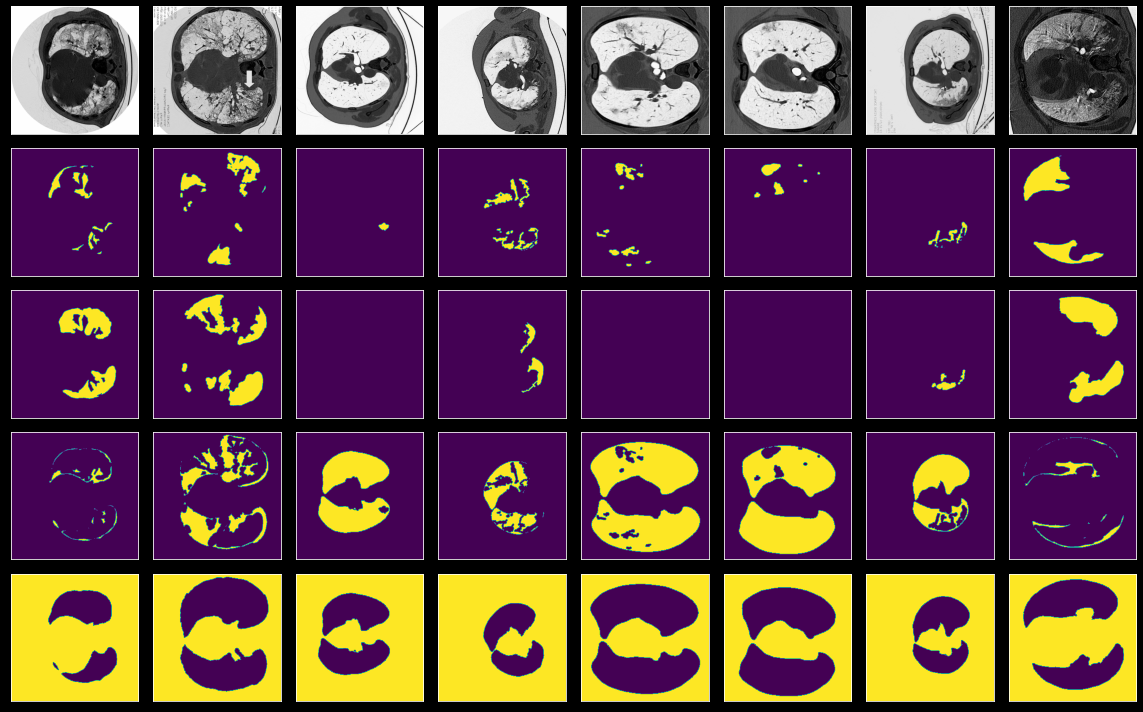

In [ ]:
visualize(imgs, msks)

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, labels):
        'Initialization'
        self.labels = labels
        self.x = x

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        x = self.x[index]
        y = self.labels[index]
        # Adjusting the shape of the images to make them proper for convolutional layers
        x = x.reshape(1, 512, 512)
        y_out = np.zeros((y.shape[2], y.shape[0], y.shape[1]))
        for ch in range(y.shape[-1]):
            y_out[ch] = y[:, :, ch]
        return x, y_out
      
dataset = Dataset(imgs, msks)

## Split Dataset

In [ ]:
# 0.1 for test
from torch.utils.data import random_split

train_size = int(np.ceil(0.9*len(dataset)))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

## DataLoaders

In [ ]:
# batchsize < 5
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True)

torch.Size([4, 512, 512])


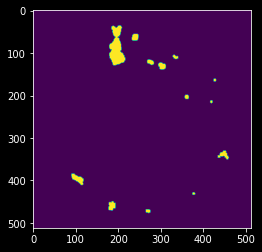

In [ ]:
for X, y in train_loader:
    print(y[:, [0, 1], :, :].sum(axis=1).shape)
    plt.imshow(y[:, [0, 1], :, :].sum(axis=1)[0]>0)
    break


## Unet


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device.")

class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()

        ###########################################
        ########### Your Code below
        self.conv2d_block = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(), 
            nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU()
        )
        self.conv2d_trans = nn.ConvTranspose2d(channel_in, channel_in//2, kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.1)
        ###########################################

    def forward(self, x1, x2):

        ###########################################
        ########### Your Code  
        x1 = self.conv2d_trans(x1)
        diffx = x2.size()[3] - x1.size()[3]
        diffy = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diffx//2, diffx - diffx//2, diffy//2, diffy - diffy//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.dropout(x)
        x = self.conv2d_block(x)
        return x 
        ###########################################

class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()

        ###########################################
        ########### Your Code  
        self.conv2d_block = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
            nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU()
        )
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ###########################################
        
    
    def forward(self, x):

        ###########################################
        ########### Your Code 
        c = self.conv2d_block(x)
        p = self.max_pool(c)        
        return c, p
        ###########################################


class UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet, self).__init__()

        ###########################################
        ########### Your Code  
        self.channel_in = channel_in
        self.classes = classes
        self.down1 = Down(channel_in, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up3 = Up(64, 32)
        self.out_conv = nn.Conv2d(32, classes, kernel_size=1)
        self.dropout = nn.Dropout(p=0.1)
        ###########################################
        
    def forward(self, x):
        
        ###########################################
        ########### Your Code 
        c1, p1 = self.down1(x)
        p1 = self.dropout(p1)
        c2, p2 = self.down2(p1)
        p2 = self.dropout(p2)
        c3, p3 = self.down3(p2)
        p3 = self.dropout(p3)
        c4, p4 = self.down4(p3)
        u5 = self.up1(c4, c3)
        u6 = self.up2(u5, c2)
        u7 = self.up3(u6, c1)
        out = self.out_conv(u7)
        return out
        ###########################################
    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2.0))
        nn.init.constant_(m.bias, 0.1)

model = UNet(1, 1).to(device)
model.apply(weights_init)

Using cuda device.


UNet(
  (down1): Down(
    (conv2d_block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Down(
    (conv2d_block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (max_pool): MaxPool2d(kernel_size=2, strid

## IoU

In [ ]:
def iou(preds, msks):
    batch_iou = 0
    for pred,  msk in zip(preds, msks):
        msk = msk.reshape(1, *msk.shape)
        pred = torch.sigmoid(pred) > 0.5
        intersection = (pred * msk).sum().item()
        total = (pred + msk).sum().item()
        union = total - intersection
        smooth = 1e-5
        batch_iou += (intersection+smooth)/(union+smooth)
    return batch_iou/len(preds)        


# Optimizer and Loss Function

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

## Train and Test

In [ ]:
def train(train_loader, model, loss_fn, optimizer):
    train_iou, train_loss= 0, 0
    model.train()
    for batch_num, (X, msks) in enumerate(train_loader):
        X, msks = X.to(device), msks.to(device)
        pred = model(X)
        msks = msks[:, [0, 1], :, :].sum(axis=1)
        train_iou += iou(pred, msks)
        # y = msks[:, msk_num, :, :]
        y = msks.reshape(msks.shape[0], 1, msks.shape[1], msks.shape[2])
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_num%5==0:
            print(f"Loss: {loss.item():<10.6}   [{batch_num*len(X):>2}/{len(train_loader.dataset):<2}]")
    train_iou /= len(train_loader)
    train_loss /= len(train_loader)
    print(f"Train IoU: {train_iou*100:>15.4}") 
    return train_loss, train_iou

def test(test_loader, model, loss_fn):
    model.eval()
    test_iou, test_loss = 0, 0  
    with torch.no_grad():
        for X, msks in test_loader:
            X, msks = X.to(device), msks.to(device)
            pred = model(X)
            y = msks[:, 0, :, :]
            y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])
            test_loss += loss_fn(pred, y).item()
            test_iou += iou(pred, msks[:, 0, :, :])
    test_loss /= len(test_loader)
    test_iou /= len(test_loader)
    print(f"\nTest Loss: {test_loss:>15.6}\nTest IoU: {test_iou*100:>16.4}")
    return test_loss, test_iou

# Train the model

In [ ]:
no_epochs = 50
train_losses, train_ious = [], []
test_losses, test_ious = [], []
for epoch in range(no_epochs):
    print(f"\nEpoch {epoch+1}\n{'-'*40}")
    train_loss, train_iou = train(train_loader, model, loss_fn, optimizer)
    test_loss, test_iou = test(test_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    test_losses.append(test_loss)
    test_ious.append(test_iou)


Epoch 1
----------------------------------------
Loss: 1.50074      [ 0/90]
Loss: 0.932685     [20/90]
Loss: 0.591411     [40/90]
Loss: 0.498472     [60/90]
Loss: 0.397723     [80/90]
Train IoU:           15.41

Test Loss:        0.301471
Test IoU:            4.156

Epoch 2
----------------------------------------
Loss: 0.362957     [ 0/90]
Loss: 0.317347     [20/90]
Loss: 0.293036     [40/90]
Loss: 0.318427     [60/90]
Loss: 0.322324     [80/90]
Train IoU:            19.5

Test Loss:         0.20356
Test IoU:            11.55

Epoch 3
----------------------------------------
Loss: 0.242169     [ 0/90]
Loss: 0.379627     [20/90]
Loss: 0.207385     [40/90]
Loss: 0.216944     [60/90]
Loss: 0.258202     [80/90]
Train IoU:           22.44

Test Loss:        0.152901
Test IoU:            19.23

Epoch 4
----------------------------------------
Loss: 0.206612     [ 0/90]
Loss: 0.17771      [20/90]
Loss: 0.201146     [40/90]
Loss: 0.281172     [60/90]
Loss: 0.177176     [80/90]
Train IoU:    

## Plot the result

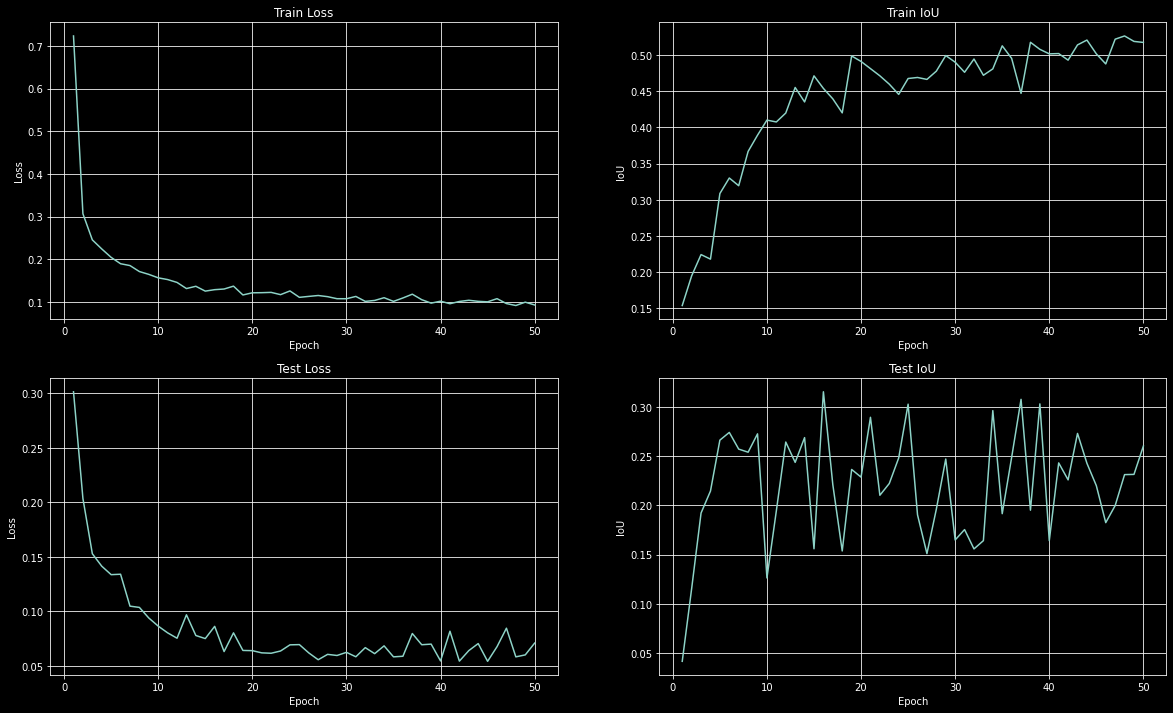

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax[0][0].plot(list(range(1, len(train_losses)+1)), train_losses)
ax[0][0].set_title("Train Loss")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Loss")
ax[0][0].grid(True)
ax[0][1].plot(list(range(1, len(train_ious)+1)), train_ious)
ax[0][1].set_title("Train IoU")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("IoU")
ax[0][1].grid(True)
ax[1][0].plot(list(range(1, len(test_losses)+1)), test_losses)
ax[1][0].set_title("Test Loss")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Loss")
ax[1][0].grid(True)
ax[1][1].plot(list(range(1, len(test_ious)+1)), test_ious)
ax[1][1].set_title("Test IoU")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("IoU")
ax[1][1].grid(True)

## Segment Output for Ground Glass

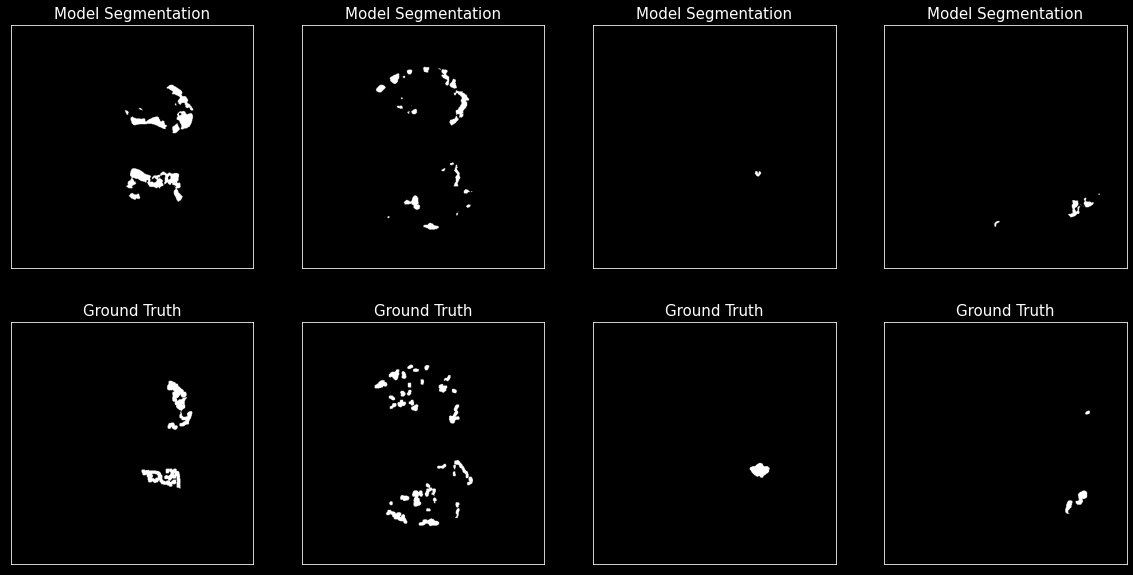

In [ ]:
# plt.style.use("default")
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
with torch.no_grad():
    for X, Y in test_loader:
        X = model(X.to(device))
        X = torch.sigmoid(X)>=0.5
        for idx, (x, y) in enumerate(zip(X, Y)):
            ax[0][idx].imshow(x[0].cpu(), cmap='gray')
            ax[1][idx].imshow(y[0].cpu(), cmap='gray')
            ax[0][idx].set_xticks([])
            ax[0][idx].set_yticks([])
            ax[1][idx].set_xticks([])
            ax[1][idx].set_yticks([])
            ax[0][idx].set_title("Model Segmentation", fontsize=15)
            ax[1][idx].set_title("Ground Truth", fontsize=15)
        break

    

## Improve U-Net (bonus)


# References
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
-https://pytorch.org/docs/stable/index.html
